In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-image-dataset-90-different-animals:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1554380%2F3952946%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T085415Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05bc7051173245430424329e189f2c486e671635794e9f197523179d77e10ab360b8b94a958b3b46489505521e6bcefeada17b26f3ba5dd41e08f361d4300dfc506a6e156088bd230029e01dfc420ac6f38380ab8658c59f6837ed542e8050047a364aa828ffb2c8d57a549821f75da979f0117b177a922de543894c24a294371a25f020b8251ec48449570967a29515ead20971ccfaa7e289933a24e2fdf3b49bff763b50834f441f2a256b0ec5d2cd4751e3446c1eda8e653a54e0aa88b9c35fd9b77112cdd9f0884655297310bf52619d1352737b85b410f5db1d37006c4d237fa8fee43fe4e047e4ec153916fc4f549dcf9f24319b489d542ee8f662ab0b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/687486f1cb.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/93fb82b04b.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/7d7f6c9750.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/0de750893f.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/2fecd5e844.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/514cd025fa.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/44931701fe.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/138f5c986e.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/9977af1a6f.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/be

### Importing Libraries

In [ ]:
import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2024-06-19 07:41:27.068356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 07:41:27.068438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 07:41:27.204114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preprocessing

In [ ]:
path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [ ]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath       labels
0  /kaggle/input/animal-image-dataset-90-differen...     elephant
1  /kaggle/input/animal-image-dataset-90-differen...      hamster
2  /kaggle/input/animal-image-dataset-90-differen...  caterpillar
3  /kaggle/input/animal-image-dataset-90-differen...     hedgehog
4  /kaggle/input/animal-image-dataset-90-differen...          rat
(3779, 3)
--------Validation----------
                                             imgpath       labels
0  /kaggle/input/animal-image-dataset-90-differen...       pigeon
1  /kaggle/input/animal-image-dataset-90-differen...     elephant
2  /kaggle/input/animal-image-dataset-90-differen...      dolphin
3  /kaggle/input/animal-image-dataset-90-differen...           ox
4  /kaggle/input/animal-image-dataset-90-differen...  grasshopper
(1134, 3)
----------Test--------------
                                             imgpath    labels
0  /kaggle/input/animal-image-dataset-

### EDA

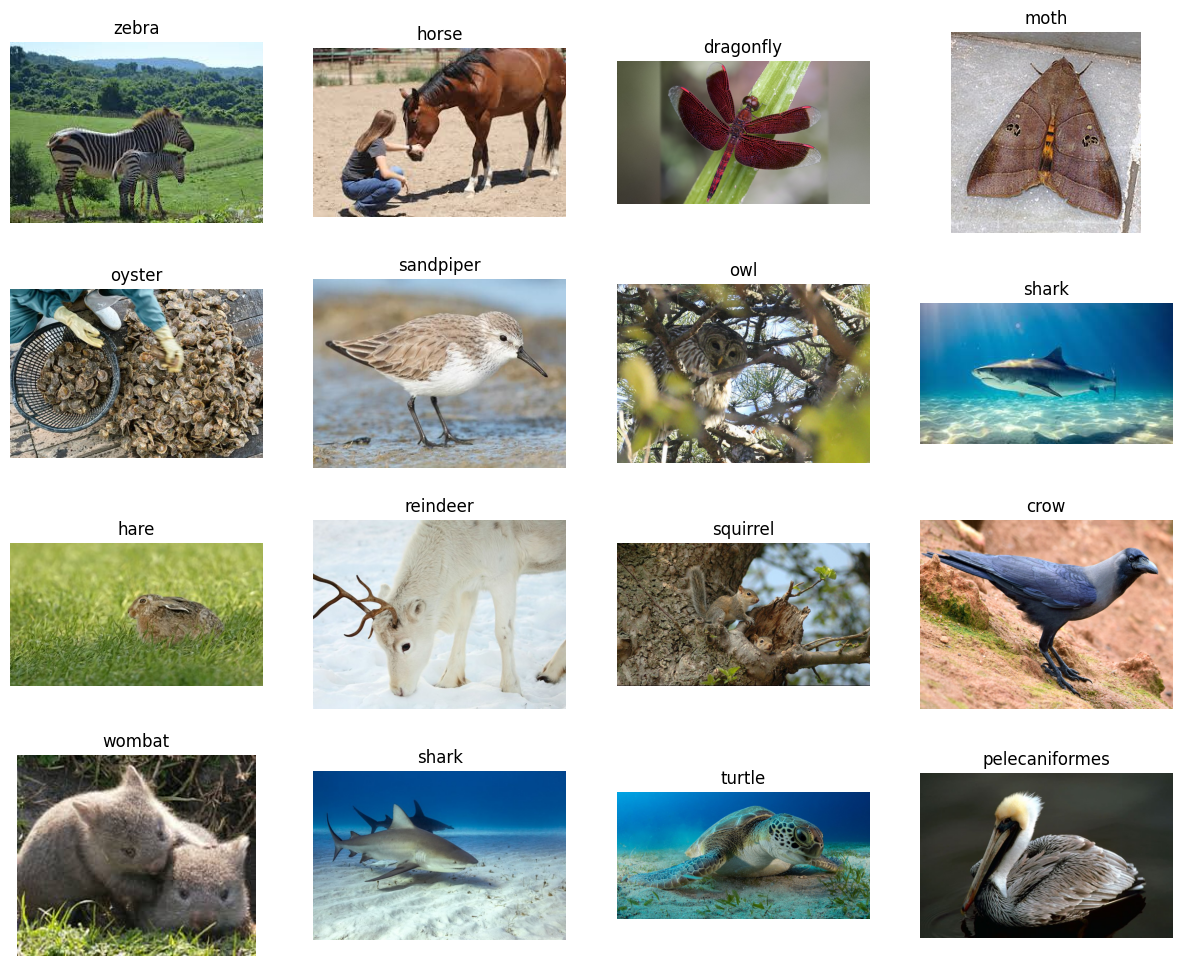

In [ ]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

### Model Training

In [ ]:
BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.


In [ ]:
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [ ]:
num_classes = len(set(train_images.classes))

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
pretrain_out = pretrained_model(inputs, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 90)             │        23,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 90)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,201,161 (42.73 MB)

 Trainable params: 417,114 (1.59 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

None


In [ ]:
import math

steps_per_epoch = math.ceil(len(train_images) / BATCH_SIZE)
validation_steps = math.ceil(len(val_images) / BATCH_SIZE)

history = model.fit(
    train_images,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=validation_steps,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('model1.weights.h5')

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 806ms/step - accuracy: 0.0286 - loss: 5.4043 - val_accuracy: 0.1111 - val_loss: 5.5936 - learning_rate: 5.0000e-04
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.0953 - loss: 4.1917 - val_accuracy: 0.0889 - val_loss: 4.6726 - learning_rate: 5.0000e-04
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.1624 - loss: 3.7538 - val_accuracy: 0.3667 - val_loss: 2.9388 - learning_rate: 5.0000e-04
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.3595 - loss: 2.9286 - val_accuracy: 0.4333 - val_loss: 2.5834 - learning_rate: 5.0000e-04
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.3939 - loss: 2.9925 - val_accuracy: 0.4333 - val_loss: 2.2837 - learning_rate: 5.0000e-04
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.4010 - loss: 2.5997 - val_accuracy: 0.5778 - val_loss: 1.8888 - learning_rate: 5.0000e-04
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.4454 - l

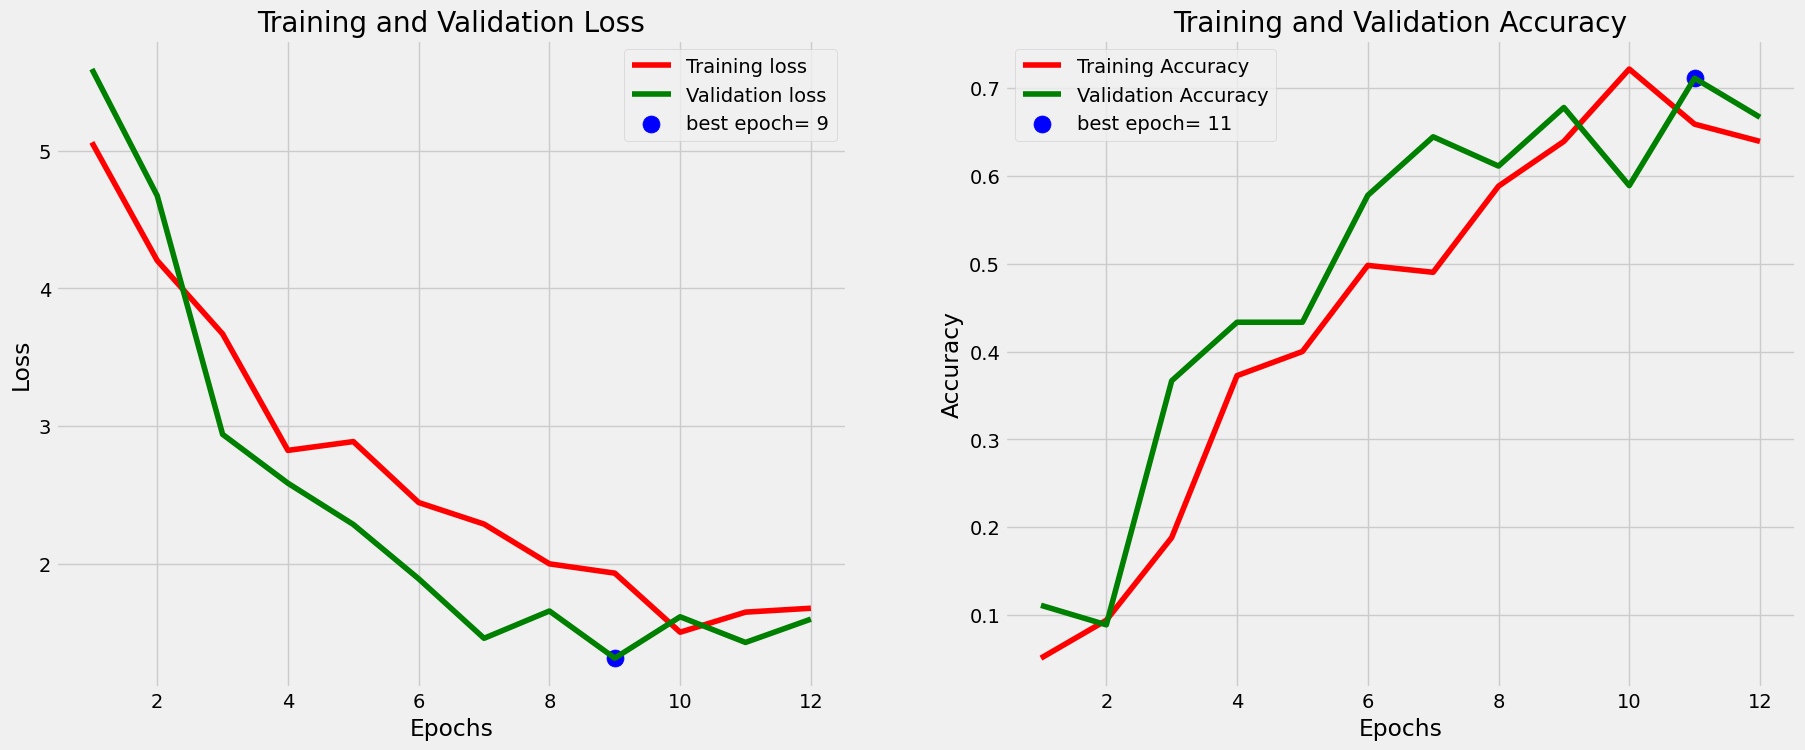

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 1.51282
Test Accuracy: 66.74%


In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

for l in pretrained_model.layers[:20]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

import math
steps_per_epoch = math.ceil(len(train_images) / BATCH_SIZE)
validation_steps = math.ceil(len(val_images) / BATCH_SIZE)

history = model.fit(
    train_images,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=validation_steps,
    epochs=35
)

input_layer_11 False
rescaling_10 False
normalization_5 False
rescaling_11 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 90)             │        23,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activationLayer (Activation)    │ (None, 90)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,201,161 (42.73 MB)

 Trainable params: 417,114 (1.59 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

None
Epoch 1/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 70s 957ms/step - accuracy: 0.4640 - loss: 2.3427 - val_accuracy: 0.2000 - val_loss: 5.6070
Epoch 2/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.4313 - loss: 2.6028 - val_accuracy: 0.2556 - val_loss: 4.2793
Epoch 3/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.5283 - loss: 2.0871 - val_accuracy: 0.3444 - val_loss: 4.0444
Epoch 4/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.5585 - loss: 1.6145 - val_accuracy: 0.3444 - val_loss: 3.4269
Epoch 5/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.5365 - loss: 1.7155 - val_accuracy: 0.3333 - val_loss: 3.0477
Epoch 6/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.5639 - loss: 1.7745 - val_accuracy: 0.3222 - val_loss: 2.8373
Epoch 7/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.5813 - loss: 1.7777 - val_accuracy: 0.2556 - val_loss: 7.2881
Epoch 8/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.6331 - loss: 1.6345 - val_accura

W0000 00:00:1718786088.639667     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.6475 - loss: 1.1821 - val_accuracy: 0.5926 - val_loss: 1.5382
Epoch 14/35
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5611 - loss: 1.7472

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.5944 - loss: 1.5173 - val_accuracy: 0.7000 - val_loss: 1.1516
Epoch 15/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6790 - loss: 1.1582 - val_accuracy: 0.7222 - val_loss: 1.0438
Epoch 16/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.7496 - loss: 1.0127 - val_accuracy: 0.7333 - val_loss: 1.0514
Epoch 17/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.6602 - loss: 1.2541 - val_accuracy: 0.7667 - val_loss: 0.7995
Epoch 18/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.7199 - loss: 1.0245 - val_accuracy: 0.7333 - val_loss: 0.8796
Epoch 19/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.7055 - loss: 1.1345 - val_accuracy: 0.7111 - val_loss: 0.9078
Epoch 20/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.6902 - loss: 1.0256 - val_accuracy: 0.8444 - val_loss: 0.6286
Epoch 21/35
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.6628 - loss: 1.4001 - val_accuracy: 0.7667 

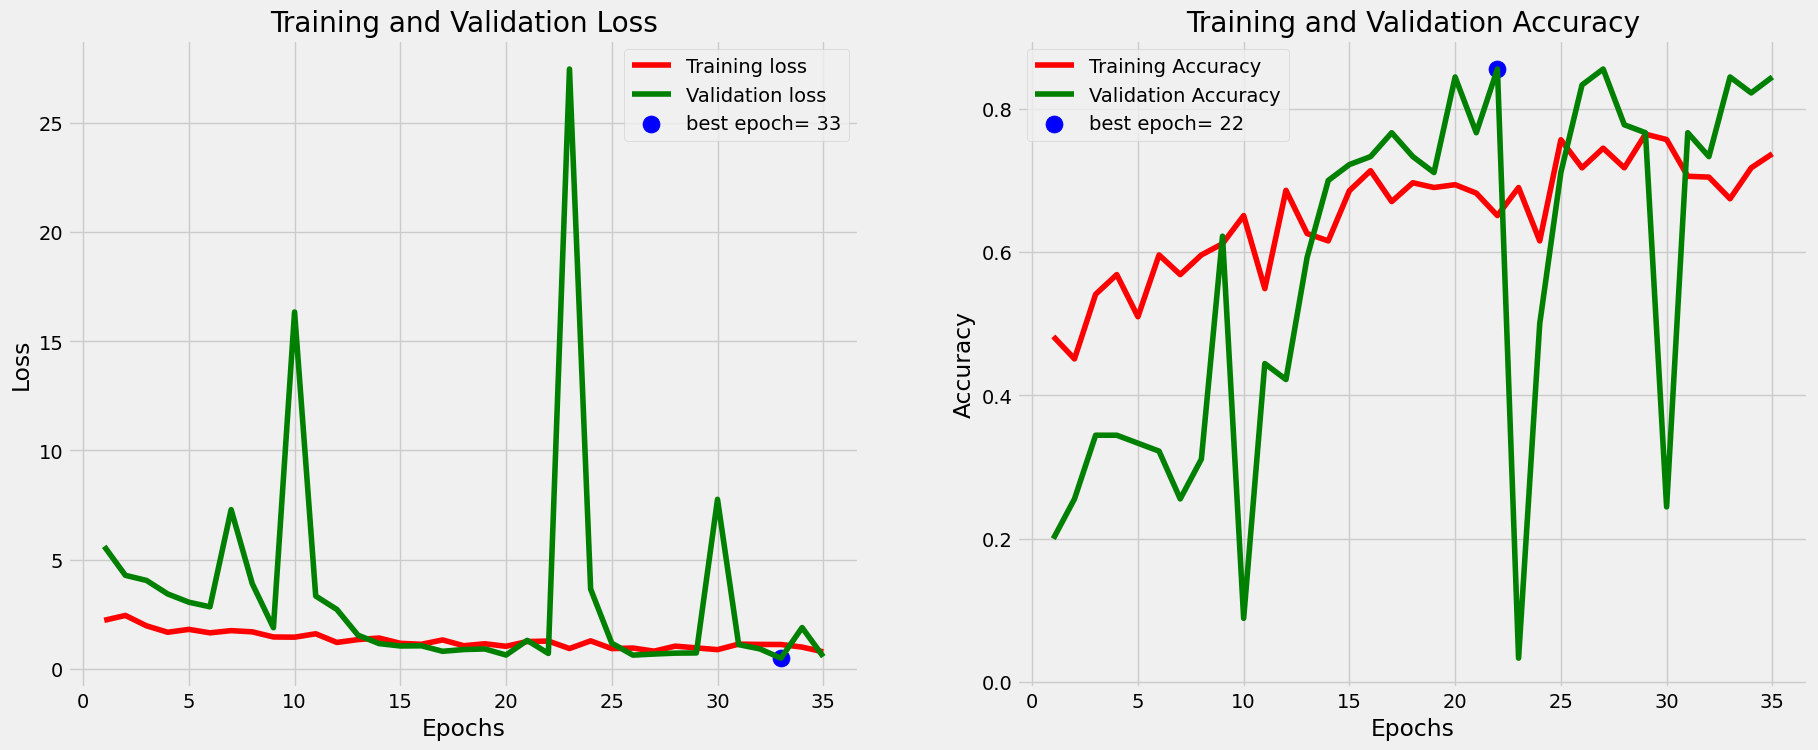

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.75544
Test Accuracy: 80.49%


In [ ]:
model.export('Animal Classification')

Saved artifact at 'Animal Classification'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputLayer')
Output Type:
  TensorSpec(shape=(None, 90), dtype=tf.float32, name=None)
Captures:
  132484242240640: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132484242242928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132484255729968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242397264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242398144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242398848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242399904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242404480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242403248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132484242393392: TensorSpec(shape=(), dtype=tf.resource, name=

### Predictions

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step
F1 Score: 0.7923797045365673
                precision    recall  f1-score   support

      antelope       1.00      0.60      0.75         5
        badger       0.88      1.00      0.93         7
           bat       0.00      0.00      0.00         3
          bear       1.00      1.00      1.00         4
           bee       1.00      0.80      0.89         5
        beetle       0.50      1.00      0.67         4
         bison       0.75      0.75      0.75         4
          boar       0.50      1.00      0.67         3
     butterfly       1.00      0.75      0.86         4
           cat       1.00      0.75      0.86         8
   caterpillar       1.00      0.50      0.67         2
    chimpanzee       0.83      0.71      0.77         7
     cockroach       1.00      0.71      0.83         7
           cow       1.00      0.67      0.80         3
        coyote       1.00      0.50      0.67         6
          crab       1.00      1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           53        okapi                 20   
1            1           83       turkey                 83   
2            2           74        shark                 74   
3            3           44     ladybugs                 44   
4            4           57           ox                 57   
5            5           59        panda                 59   
6            6           68          rat                 68   
7            7           13          cow                  6   

  Prediction Classes                                               Path  \
0             donkey  /kaggle/input/animal-image-dataset-90-differen...   
1             turkey  /kaggle/input/animal-image-dataset-90-differen...   
2              shark  /kaggle/input/animal-image-dataset-90-differen...   
3           ladybugs  /kaggle/input/animal-image-dataset-90-differen...   
4                 ox  /kaggle/input/animal-image-dataset-90-differen...   
5              panda  /kaggle/input/animal-image-dataset-90-differen...   
6                rat  /kaggle/input/animal-image-dataset-90-differen...   
7              bison  /kaggle/input/animal-image-dataset-90-differen...   

   Prediction Probability  
0                0.575840  
1                0.962237  
2                0.982494  
3                0.996353  
4                0.700213  
5                0.999982  
6                0.616228  
7                0.305082

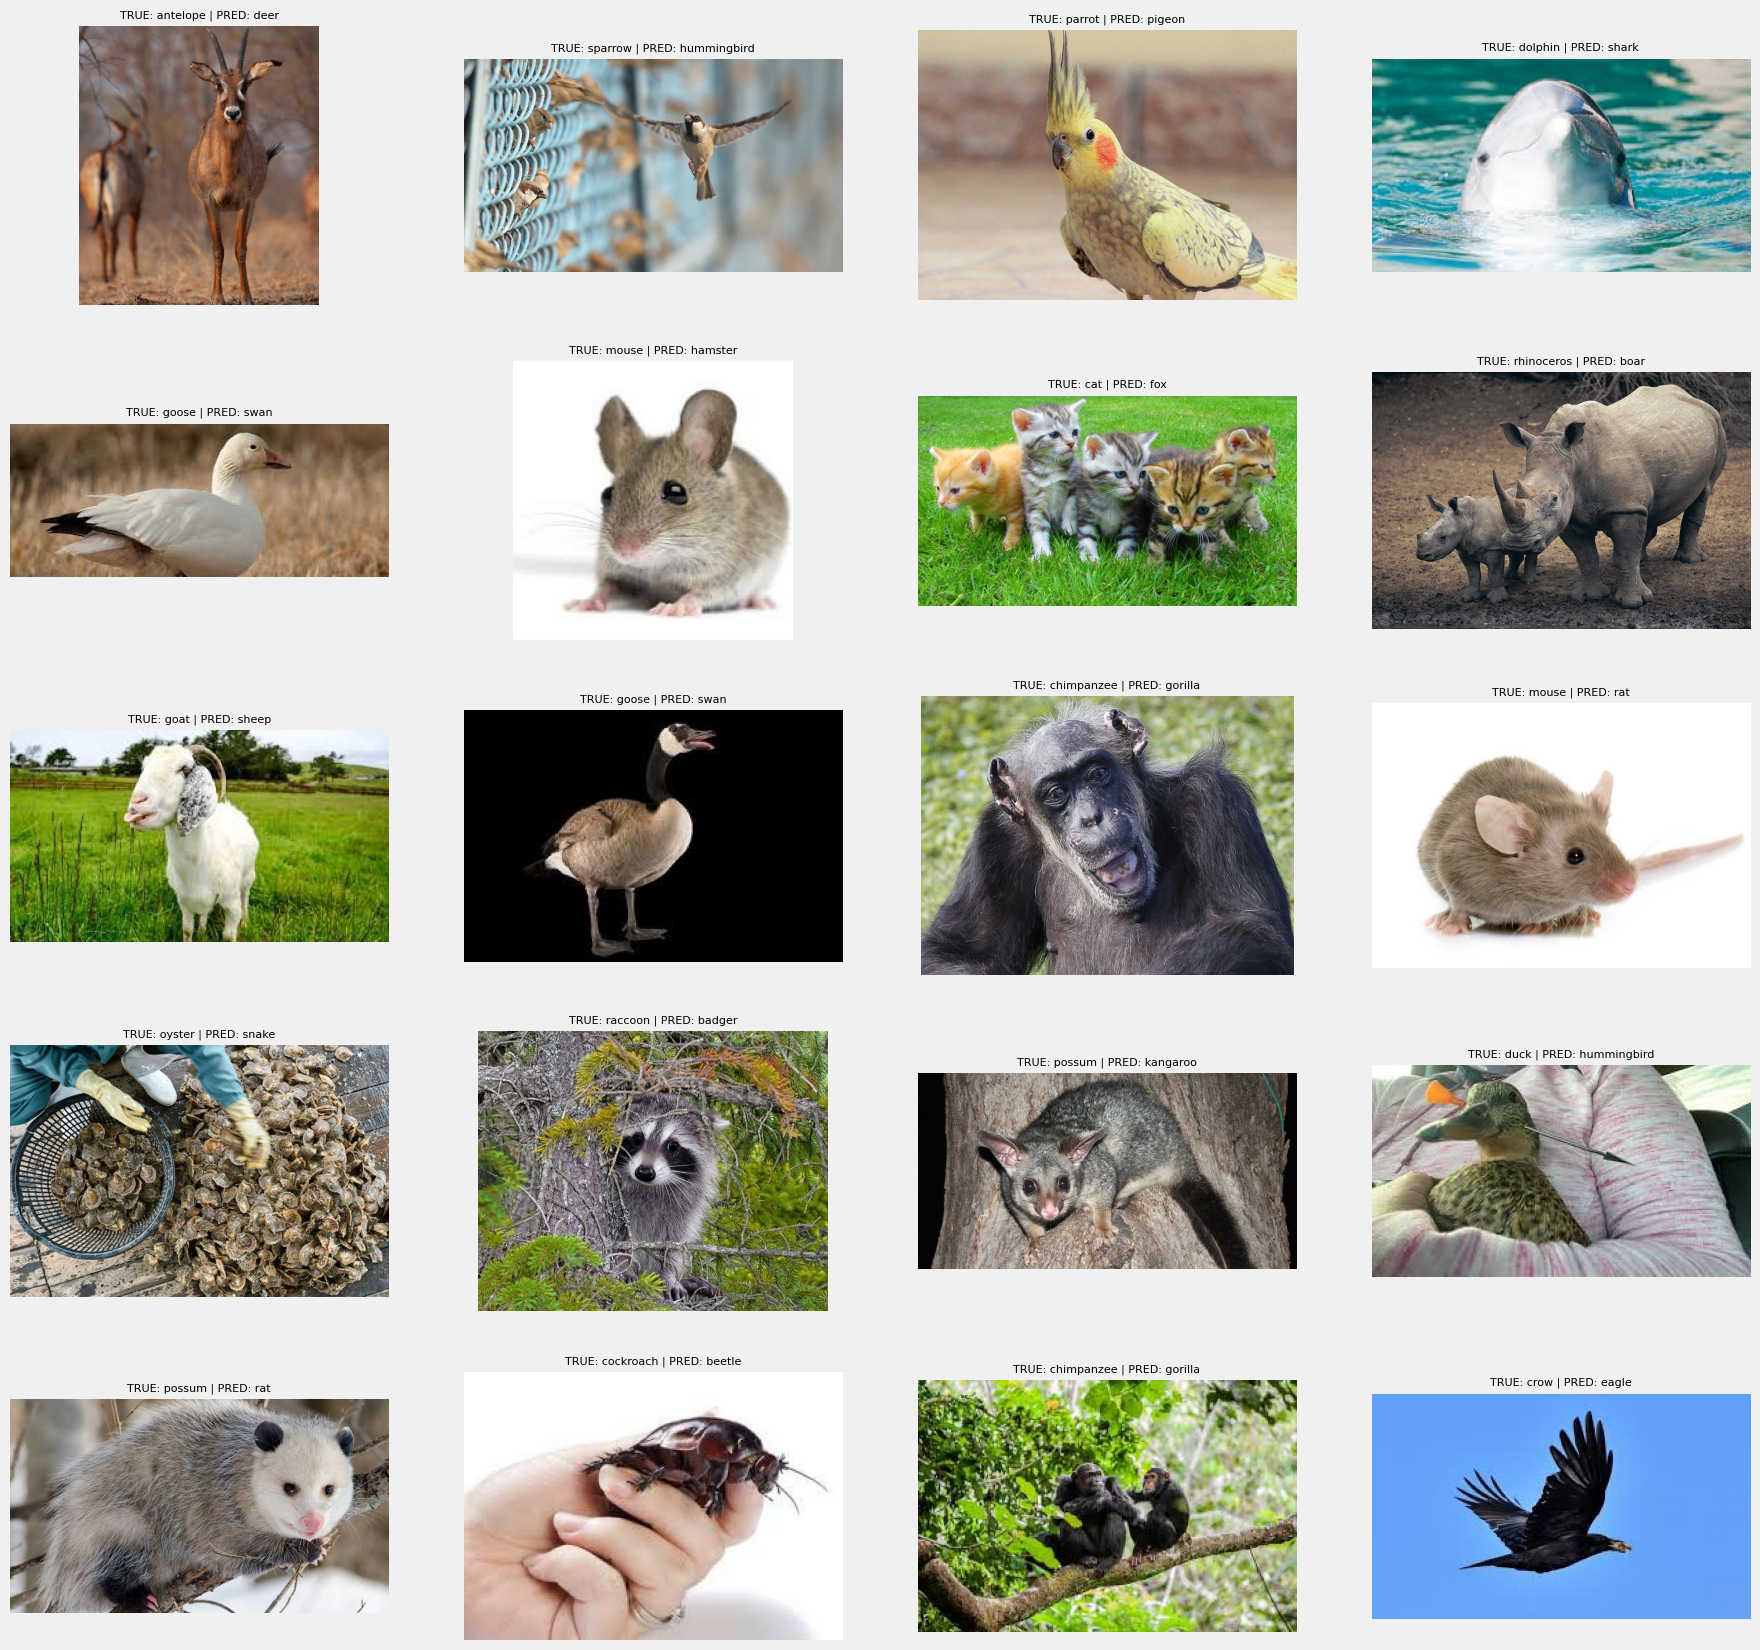

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step


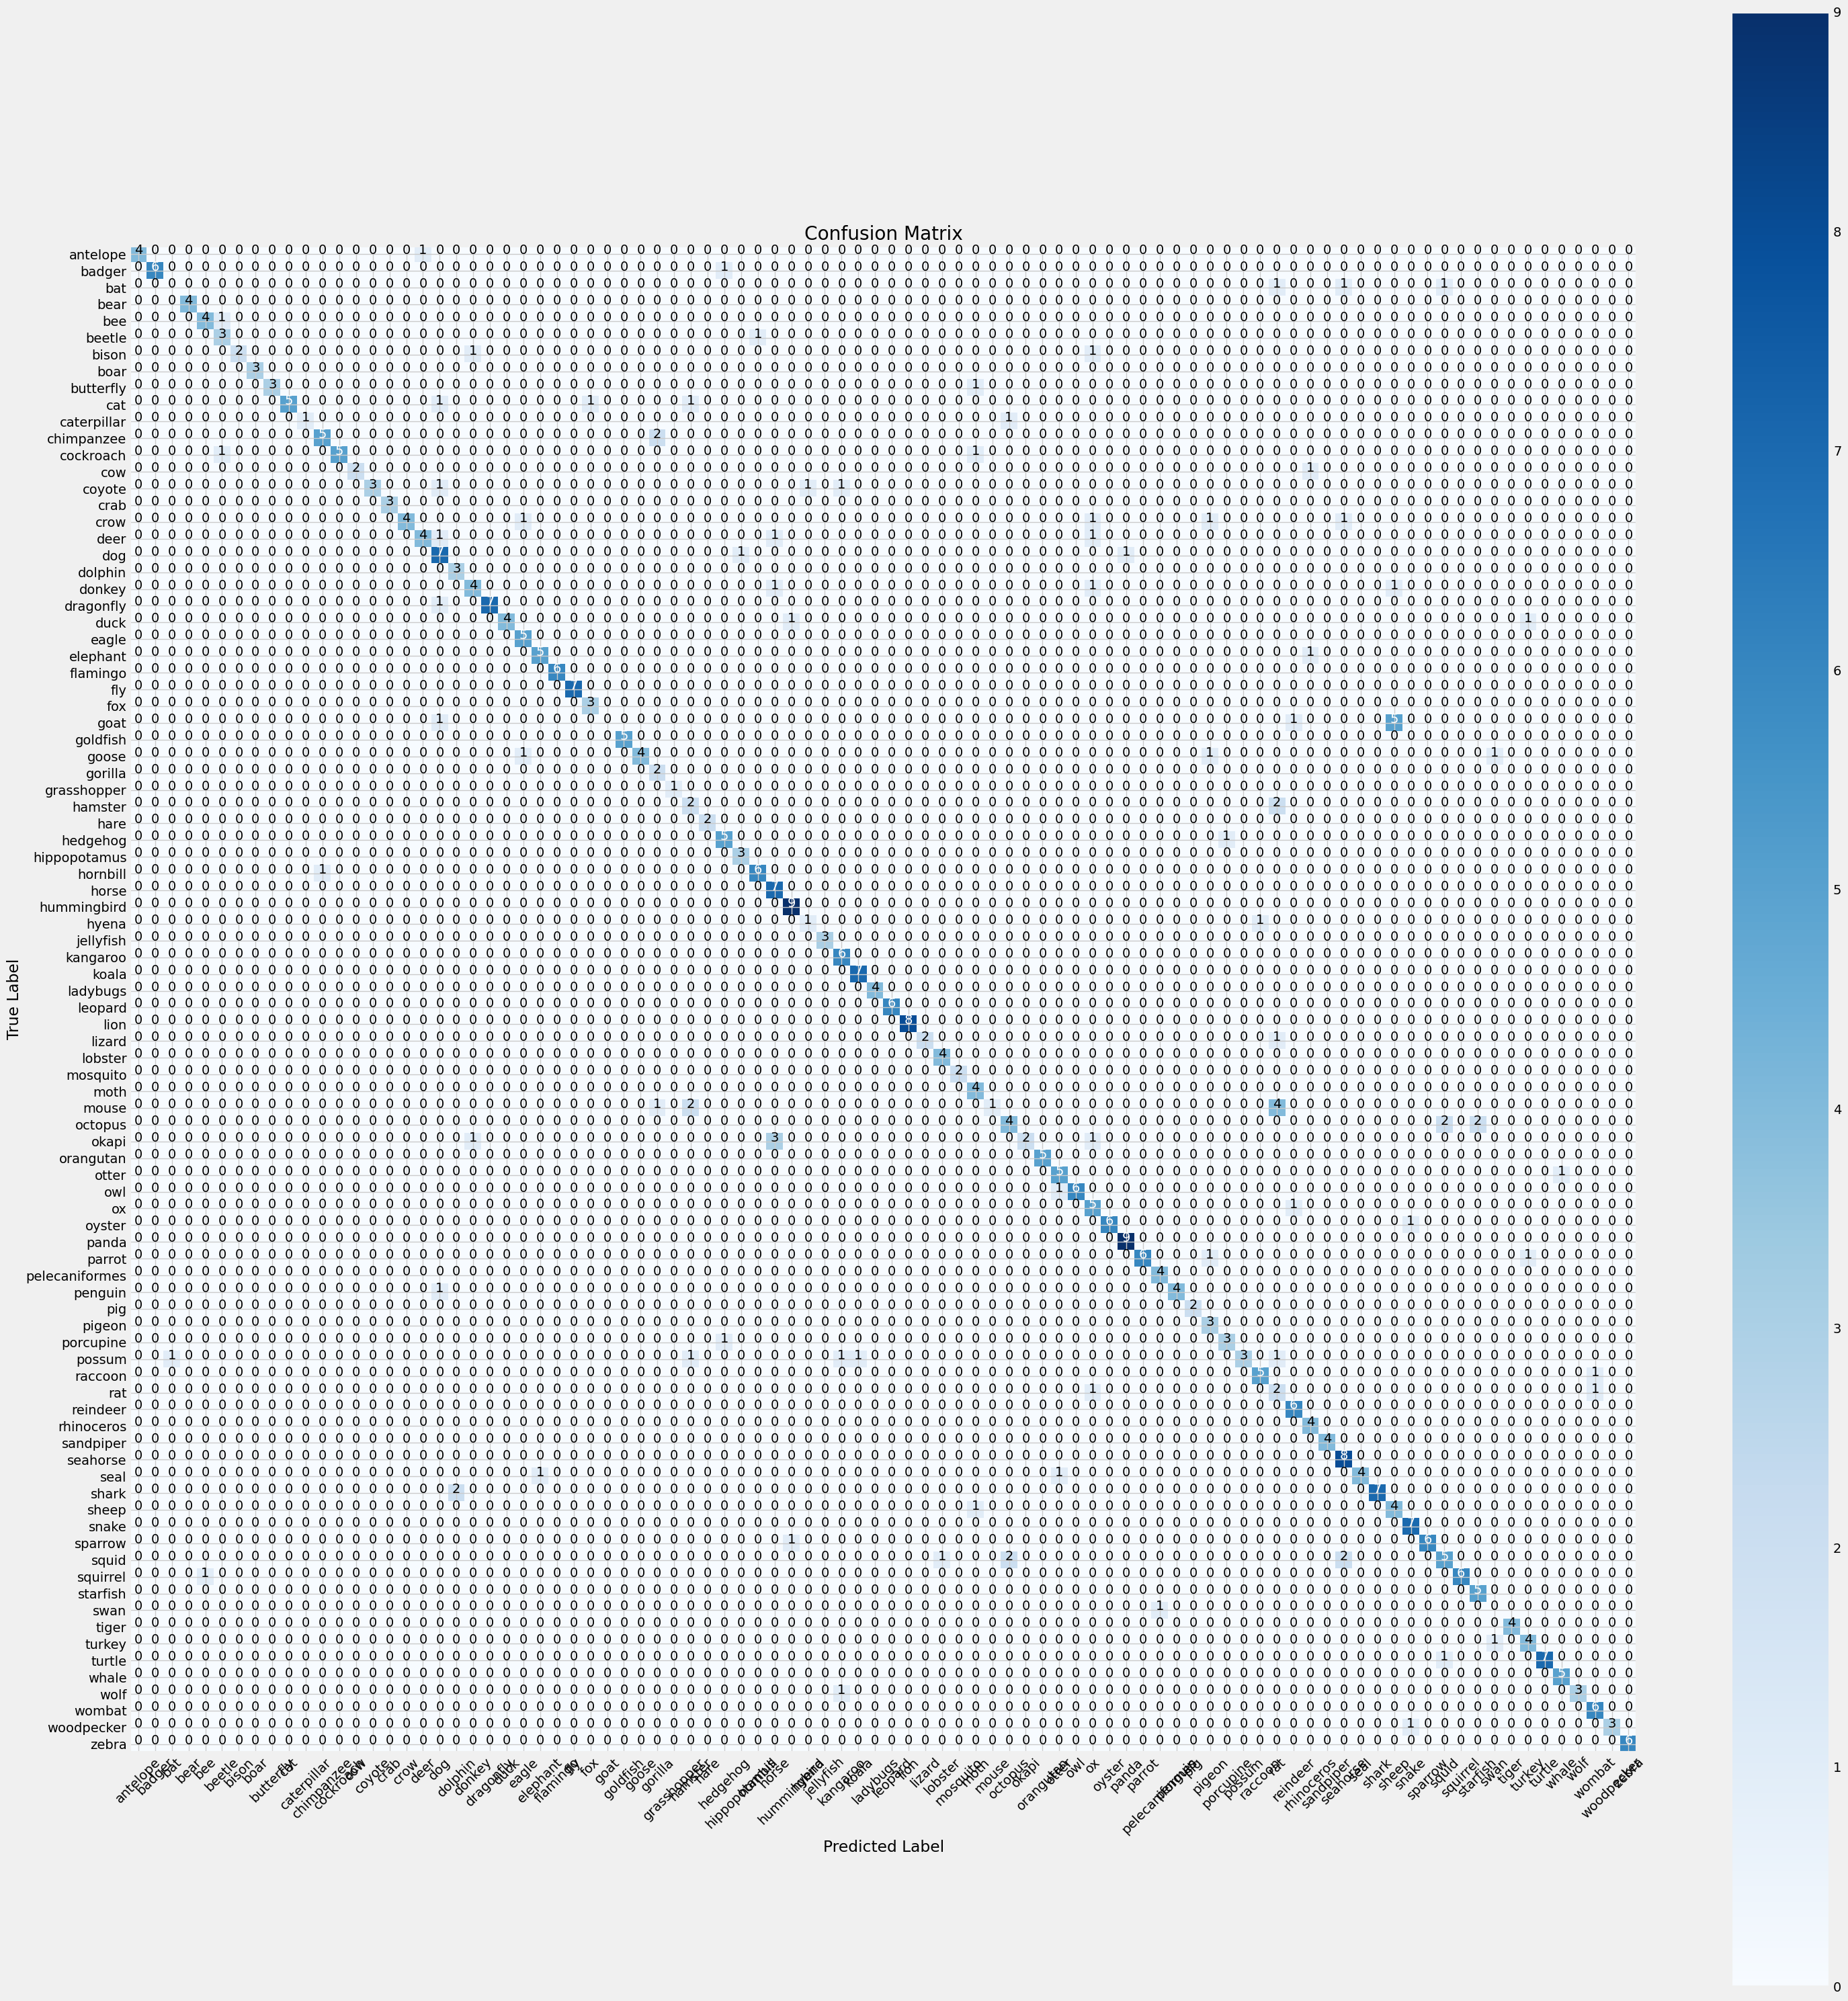

In [ ]:
preds = model.predict(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize=(30, 30))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
from IPython.display import FileLinks
FileLinks(r'/kaggle/working/Animal Classification')

/kaggle/working/Animal Classification/
  saved_model.pb
  fingerprint.pb
/kaggle/working/Animal Classification/variables/
  variables.index
  variables.data-00000-of-00001